In [1]:
# move this down
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import plotly.express as px

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pickle
import csv
import time

In [4]:
# Finds list of whiskey names
'''
URL1 = 'https://scotchnoob.com/reviews/?pagenum=1&dateFrom=11/10/2010&dateTo=04/11/2021&shownum=-1&orderBy=title&order=ASC&priceFrom=0&priceTo=-1&region=All&rating=All&tag_peated=false&tag_sherried=false&tag_indie=false'

page1 = requests.get(URL1)

pickle.dump(page1, open('list-of-bottles.p', 'wb'))'''

page1 = pickle.load(open('list-of-bottles.p', 'rb'))

soup1 = BeautifulSoup(page1.text, 'lxml')


In [5]:
# Finds whiskey names
whiskey_names = []

name0 = soup1.find('div', {'id' : 'filter_results'})

whiskey_names = name0.find_all('h4')


for w in range(len(whiskey_names)):

    whiskey_names[w] = whiskey_names[w].text




# Finds whiskey urls

whiskey_urls = []

for tag in name0.find_all('a', href = True):
   
    if (str(tag['href']) == '/?page_id=264') : continue
    whiskey_urls.append(str(tag['href']))



# Finds description of whiskey

whiskey_files = []
whiskey_desc = []

for r in range(len(whiskey_names)):
    whiskey_files.append(str(whiskey_names[r]).replace(' ',''))
    
    if (whiskey_files[r] == 'TheBenRiach(19year)Peated/OlorosoFinish1994'): 
        page0 = pickle.load(open('pages/TheBenRiach(19year)Peated-OlorosoFinish1994.p', 'rb'))
    
    else:
        page0 = pickle.load(open('pages/' + whiskey_files[r] + '.p', 'rb'))
    
    
    soup0 = BeautifulSoup(page0.text, 'lxml')
 
    
    # Builds temp array to join and append to whiskey_desc array
    
    class0 = soup0.find('div', {'class' : 'entry-content'})
    class1 = class0.find_all('p')
    
   
    whiskey_desc_mass = []
    
    for free in class1: 
        whiskey_desc_mass.append(str(free.text).replace(':', '').replace(',',''))
        
    whiskey_desc.append(''.join(whiskey_desc_mass))
    

In [16]:
whiskey_dict = {'id': whiskey_names, 'description': whiskey_desc}

df = pd.DataFrame(whiskey_dict)

df.to_csv('whiskey-reviews.csv', index = False)

In [7]:
merged_whiskeys = []

for i in range(len(whiskey_names)):
    merged_whiskeys.append(str(whiskey_names[i]) + '- ' + str(whiskey_desc[i]))

    
whiskey_dict = {'description': merged_whiskeys}

df = pd.DataFrame(whiskey_dict)

df.to_csv('merged-whiskey-reviews.csv', index = False)  

In [8]:


whiskey_dict = {'id': range(509), 'description': merged_whiskeys}

df = pd.DataFrame(whiskey_dict)

df.to_csv('indexed-whiskey-reviews.csv', index = False)

In [65]:
pickle.dump(whiskey_desc, open('whiskey-desc.p', 'wb'))
pickle.dump(whiskey_names, open('whiskey-names.p', 'wb'))
pickle.dump(whiskey_urls, open('whiskey-urls.p', 'wb'))
pickle.dump(whiskey_dict, open('whiskey-dictionary.p', 'wb'))

In [175]:
# Don't run this again!!
# Don't delete, for posssible reference

whiskey_files = []
for r in range(len(whiskey_names)):
    
    URL0 = whiskey_urls[r]
    
    page0 = requests.get(URL0)
    
    
    whiskey_files.append(str(whiskey_names[r]).replace(' ',''))
    

    if (whiskey_files[r] == 'TheBenRiach(19year)Peated/OlorosoFinish1994'): 
        pickle.dump(page0, open('pages/TheBenRiach(19year)Peated-OlorosoFinish1994.p', 'wb'))
    
    else:
        pickle.dump(page0, open('pages/' + whiskey_files[r] + '.p', 'wb'))

In [9]:
# Code for most of recommendation system comes from https://github.com/nikitaa30/Content-based-Recommender-System

# TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
# IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

ds = pd.read_csv('indexed-whiskey-reviews.csv')

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix) 
results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices] 
    results[row['id']] = similar_items[1:]

def item(id):  
    return ds.loc[ds['id'] == id]['description'].tolist()[0].split(' - ')[0] 

# Just reads the results out of the dictionary.

def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")   
    print("-------")    
    recs = results[item_id][:num]   
    for rec in recs: 
       print("Recommended: " + item(rec[1]) + " (score:" +      str(rec[0]) + ")")



In [23]:
recommend(1,5)

Recommending 5 products similar to 1792 Ridgemont Reserve Bourbon...
-------
Recommended: Very Old Barton 86 Proof (score:0.12985551169068832)
Recommended: Very Old Barton 100 Proof (score:0.06609890213982444)
Recommended: 1792 Port Finish Bourbon (score:0.05732192759374112)
Recommended: Buffalo Trace Bourbon (score:0.05482786827201038)
Recommended: Very Old Barton 90 Proof (score:0.04723282091190351)


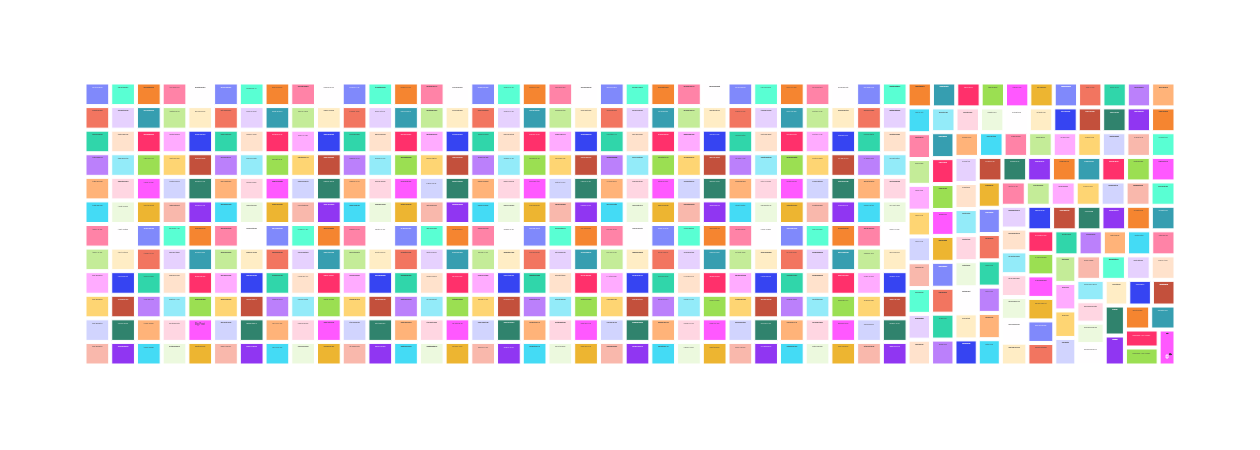

In [22]:
fig = px.treemap(df, path = ['id', 'description'])
fig.show()